# Standart Input for Sensor Based Time Series

This notebook explores a standart way to sensor based time series. The idea is the following:

Different Datasets have different sensors with different sampling frequencies and value ranges. To cope with that we do: Create a representation with the maximum frequency the framework can handle, and fill in the timespots who are missing. This also allows for uneven distributed time (we just assign it to the nearest slot). Also we normalise globally with IQR and locally and feed in both values for training

In [1]:
# imports
import numpy as np
import pandas as pd
import scipy
import torch
from torch import nn
import matplotlib.pyplot as plt
import utils as ut
import functools
%matplotlib inline

# Simulated Data

Before working with physiological datasets we use a simulated dataset for basic experiment: A noisy sinus and later a misture out of noisy sinus waves.

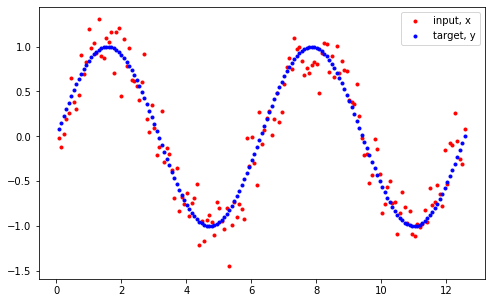

In [3]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 40

# generate evenly spaced data pts
times_pi = 4
shown_seq_length = times_pi*(seq_length + 1)
time_steps = np.linspace(0, times_pi*np.pi, shown_seq_length)
mu_noise, sigma_noise = 0, 0.2
noise = np.random.normal(mu_noise, sigma_noise, shown_seq_length)
data = np.sin(time_steps)
noisy_data = data+noise
data.resize((shown_seq_length, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = noisy_data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

Now our idea is to make matrices with the maximum sampling frequency, with a data column where missing values are filled and a missing values column

In [12]:
def basic_representation(data, num_rows_per_second, desired_rows_per_second, time_axis=0, metadata_axis=1):
    assert num_rows_per_second < desired_rows_per_second, "we assume we approximate to a maximal frequency given the data here"
    assert len(data.shape)==2, "we currently only consider 2D datasets"
    
    n, m = data.shape[time_axis], data.shape[metadata_axis]
    idx = np.array(list(range(n)))*(desired_rows_per_second-num_rows_per_second)
    nn = idx[-1]+1
    new_shape = (nn, m+1)
    result = np.zeros(new_shape)
    result[idx,:-1] = data
    neg_idx = [i for i in list(range(nn)) if i not in idx]
    result[neg_idx,-1] = 1
    return result

In [15]:
mini_example = np.array([[1,1], [2,2], [3,3], [4, 4], [5,1], [6,2], [7,3], [8, 4]])
mini_example.shape

(8, 2)

In [16]:

expanded_mini = basic_representation(mini_example, 4, 6)
expanded_mini

array([[1., 1., 0.],
       [0., 0., 1.],
       [2., 2., 0.],
       [0., 0., 1.],
       [3., 3., 0.],
       [0., 0., 1.],
       [4., 4., 0.],
       [0., 0., 1.],
       [5., 1., 0.],
       [0., 0., 1.],
       [6., 2., 0.],
       [0., 0., 1.],
       [7., 3., 0.],
       [0., 0., 1.],
       [8., 4., 0.]])

## Test is with the sinus signal

In [18]:
noisy_data.shape

(164,)

In [20]:
expanded_sinus = basic_representation(noisy_data.reshape(len(noisy_data),1), 20, 40)
expanded_sinus.shape

(3261, 2)

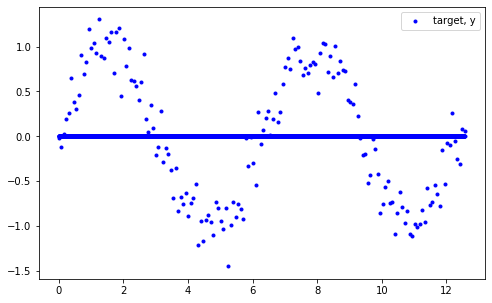

In [24]:
plt.figure(figsize=(8,5))

time_steps_expanded = np.linspace(0, times_pi*np.pi, 3261)

plt.plot(time_steps_expanded, expanded_sinus[:,0], 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [2]:
ts_length = 1000
segment_base_length = 13
ts_types = ['high', 'low']
def h(x):
    for i in range(x): yield (i, 1)
def l(x):
    for i in range(x): yield (i, 0)
ts_generators = {
    'high' : h,
    'low' : l
}
tsc = ut.TimeSeriesCreator(ts_length, segment_base_length, ts_types, ts_generators)
tsc.ts

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       ...,
       [10,  1],
       [11,  1],
       [12,  1]])

In [4]:
tsc.ts.shape


(988, 2)

In [21]:
ts_length = 1500
points_per_thing = 40
segment_base_length = 80
spike_jiggle_offsets = 3
square_jiggle_offsets = 10
ts_types = ['sinus', 'square', 'spikes', 'flat_plus_peaks']

def sinus(x, offset, points_per_pi):
    times_pi = x / points_per_pi
    time_steps = np.linspace(0, times_pi * np.pi, x)
    time_steps = time_steps + offset
    data = np.sin(time_steps)
    for ts, s in zip(time_steps, data): yield (ts, s)

sin_callback = functools.partial(sinus, points_per_pi=points_per_thing)

def square(x, offset, points_per_square, square_jiggle_offsets):
    times_pi = x / points_per_square
    time_steps = np.linspace(0, times_pi * np.pi, x)
    time_steps = time_steps + offset
    val = 1
    cnt = 0
    interval = points_per_square + np.random.random_integers(0, square_jiggle_offsets)
    for ts in time_steps:
        yield (ts, val)
        if cnt == interval:
            if val == 1: val = -1
            else: val = 1
            interval = points_per_square + np.random.random_integers(0, square_jiggle_offsets)
            cnt = 0
        cnt += 1

square_callback = functools.partial(square, points_per_square=20)

def spikes(x, offset, points_per_jig, spike_jiggle_offsets):
    times_pi = x / points_per_jig
    time_steps = np.linspace(0, times_pi * np.pi, x)
    time_steps = time_steps + offset
    val = 1
    cnt = 0
    interval = points_per_thing + np.random.random_integers(0, spike_jiggle_offsets)
    for ts in time_steps:
        yield (ts, ((cnt/points_per_thing)*2-1)*val)
        cnt += 1
        if cnt == interval:
            cnt = 0
            val = val*-1
            interval = points_per_thing + np.random.random_integers(0, spike_jiggle_offsets)

spikes_callback = functools.partial(spikes, points_per_jig=points_per_thing)

def flat_plus_peaks(x, offset, scale_for_pi):
    times_pi = x / scale_for_pi
    num_diracs = int(times_pi) # idea: we want as many peaks as we have pi segments
    time_steps = np.linspace(0, times_pi * np.pi, x)
    time_steps = time_steps + offset
    dirac_ts = np.random.choice(time_steps, num_diracs, replace=False)
    val = 1
    for ts in time_steps:
        if ts in dirac_ts:
            val = val * -1
            yield (ts, val)
        else:
            yield (ts, 0)

fpp_callback = functools.partial(flat_plus_peaks, scale_for_pi=points_per_thing)

ts_generators = {
    'sinus' : sin_callback,
    'square' : square_callback,
    'spikes' : spikes_callback,
    'flat_plus_peaks' : fpp_callback
}
tsc = ut.TimeSeriesCreator(ts_length, segment_base_length, ts_types, ts_generators)
tsc.ts

/Users/joergsimon/anaconda3/envs/pytorchcpu/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
/Users/joergsimon/anaconda3/envs/pytorchcpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
/Users/joergsimon/anaconda3/envs/pytorchcpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
/Users/joergsimon/anaconda3/envs/pytorchcpu/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead


array([[ 0.00000000e+00,  0.00000000e+00],
       [ 7.95339912e-02,  7.94501670e-02],
       [ 1.59067982e-01,  1.58398024e-01],
       ...,
       [ 1.56761497e+02, -1.00000000e+00],
       [ 1.56920565e+02, -1.00000000e+00],
       [ 1.57079633e+02, -1.00000000e+00]])

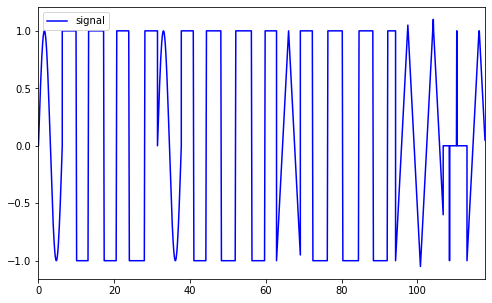

In [22]:
plt.figure(figsize=(8,5))

plt.plot(tsc.ts[:,0], tsc.ts[:,1], 'b-', label='signal') # y

plt.xlim(0, (ts_length/40)*np.pi)

plt.legend(loc='best')
plt.show()


In [2]:
ts_length = 3000 # in 100Hz
sensor1 = ut.Sensor(40, 0.0, 0.2)
sensor2 = ut.Sensor(80, 0.1, 0.1)
sensor3 = ut.Sensor(80, 0.0, 0.3)
sensor4 = ut.Sensor(20, 0.0, 0.1)

signal1, signal1_noise = sensor1.sense_signal(ts_length)
signal2, signal2_noise = sensor1.sense_signal(ts_length)
signal3, signal3_noise = sensor1.sense_signal(ts_length)
signal4, signal4_noise = sensor1.sense_signal(ts_length)


data with only two columns is assumed to have no missing value field, just return the whole index
data with only two columns is assumed to have no missing value field, just return the whole index
data with only two columns is assumed to have no missing value field, just return the whole index
data with only two columns is assumed to have no missing value field, just return the whole index


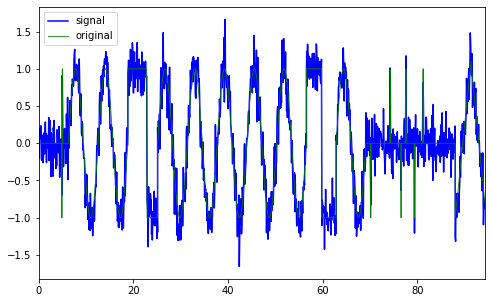

In [10]:
plt.figure(figsize=(8,5))

plt.plot(signal1_noise[:,0], signal1_noise[:,1], 'b-', label='signal') # y
plt.plot(signal1[:,0], signal1[:,1], 'g-', linewidth=0.8, label='original')

x_max = (ts_length/100)*np.pi
plt.xlim(0, x_max)

plt.legend(loc='best')
plt.show()

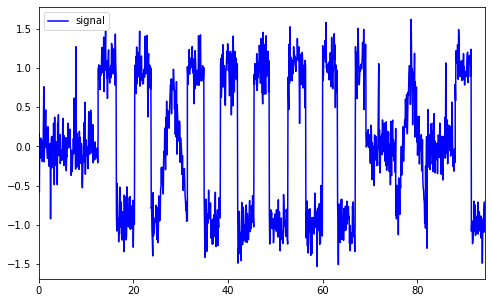

In [4]:
plt.figure(figsize=(8,5))

plt.plot(signal2_noise[:,0], signal2_noise[:,1], 'b-', label='signal') # y

x_max = (ts_length/100)*np.pi
plt.xlim(0, x_max)

plt.legend(loc='best')
plt.show()

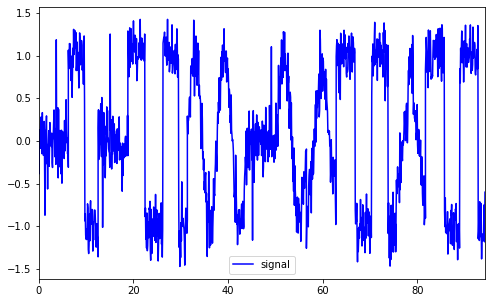

In [5]:
plt.figure(figsize=(8,5))

plt.plot(signal3_noise[:,0], signal3_noise[:,1], 'b-', label='signal') # y

x_max = (ts_length/100)*np.pi
plt.xlim(0, x_max)

plt.legend(loc='best')
plt.show()

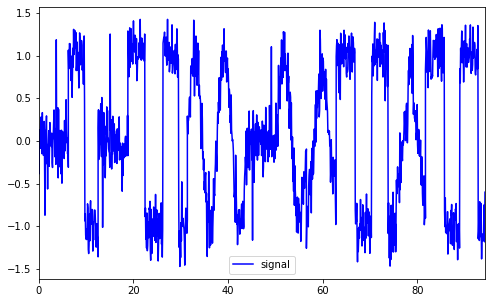

In [6]:
plt.figure(figsize=(8,5))

plt.plot(signal3_noise[:,0], signal3_noise[:,1], 'b-', label='signal') # y

x_max = (ts_length/100)*np.pi
plt.xlim(0, x_max)

plt.legend(loc='best')
plt.show()